In [1]:
import math

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from pprint import pprint
from scipy.stats import ttest_1samp
import scipy as sp

from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import r2_score

In [2]:
features = ['ADX', 'ADXR', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BETA', 'CCI', 'DX', 'HT_DCPERIOD', 'HT_TRENDMODE', 'MFI', 'RSI', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'ULTOSC', 'WILLR']

pprint(features)


['ADX',
 'ADXR',
 'AROONOSC',
 'AROON_aroondown',
 'AROON_aroonup',
 'BETA',
 'CCI',
 'DX',
 'HT_DCPERIOD',
 'HT_TRENDMODE',
 'MFI',
 'RSI',
 'STOCHF_fastk',
 'STOCH_slowd',
 'STOCH_slowk',
 'ULTOSC',
 'WILLR']


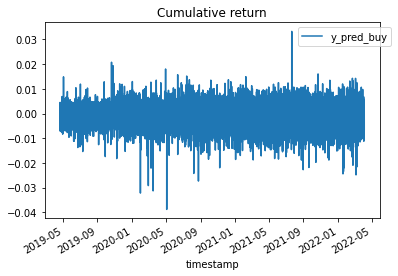

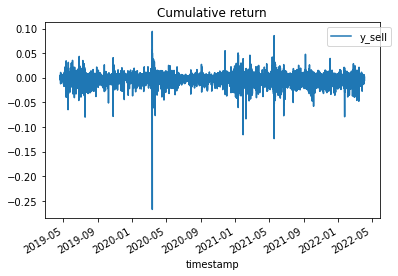

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


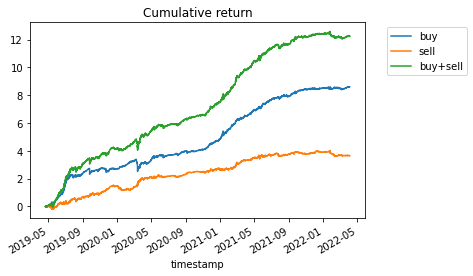

In [3]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)
model = AdaBoostRegressor(model, random_state=1)

# 通常のCV
# cv_indicies = list(KFold(n_splits=7).split(df))
# ウォークフォワード法
cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, test_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[test_idx] = estimator.predict(X[test_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

df['y_pred_buy'].plot(label='y_pred_buy')
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df['y_sell'].plot(label='y_sell')
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='buy')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='sell')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='buy+sell')
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_fit.pkl')

In [4]:
print(r2_score(df['y_buy'], df['y_pred_buy']))
print(r2_score(df['y_sell'], df['y_pred_sell']))

-0.5306428509502843
-0.5620650510312706


ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


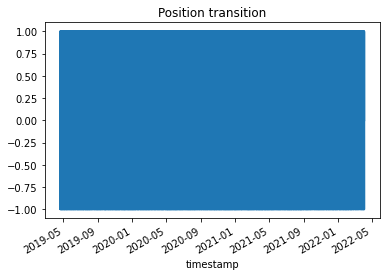

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


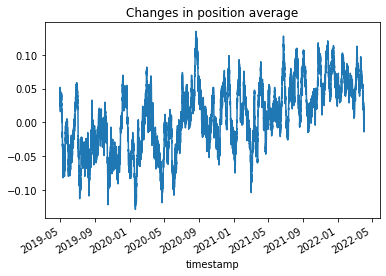

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


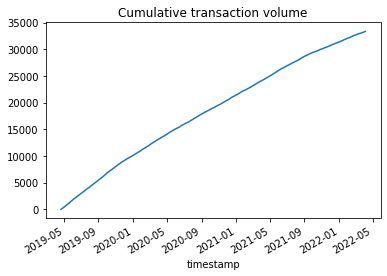

t検定
t値 6.6968918010763625
p値 2.139890127931015e-11


In [5]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('df_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('Position transition')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('Changes in position average')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('Cumulative transaction volume')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

In [6]:
# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 7
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))

p平均法 n = 7
p平均 0.17869958826012614
エラー率 0.0009508688199432862


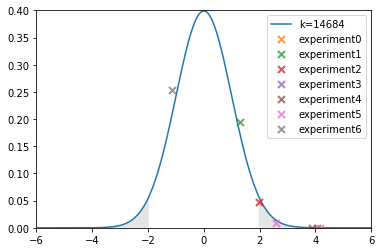

In [7]:
# 検定統計量
k = len(x)//p_mean_n -1                         # 自由度

# ここからグラフ描画
############################
xlinspace = np.linspace(-6, 6, 1000)
fig,ax = plt.subplots(1,1)

# t分布を描画する
ax.plot(xlinspace, sp.stats.t.pdf(xlinspace, k), linestyle='-', label='k='+str(k))

#　t分布に今回の確率分布を表示させる
for i in range(p_mean_n):
    x2 = x[i * x.size // p_mean_n:(i + 1) * x.size // p_mean_n]
    t, p = ttest_1samp(x2, 0)
    ax.plot(t, p, 'x', markersize=7, markeredgewidth=2, alpha=0.8, label='experiment'+str(i))

# t分布の95%信頼区間から外れた領域を描画する
bottom, up = sp.stats.norm.interval(alpha=0.95, loc=0, scale=1)
plt.fill_between(xlinspace, sp.stats.t.pdf(xlinspace, k), 0, where=(xlinspace>=up)|(xlinspace<=bottom), facecolor='black', alpha=0.1)

plt.xlim(-6, 6)
plt.ylim(0, 0.4)
 
plt.legend()
plt.show()

In [8]:
# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, 'model_y_buy.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, 'model_y_sell.xz', compress=True)

['model_y_sell.xz']